# Capstone: Airbnb Price Predictions (Singapore)

## Problem Statement
---

I will build a regression model to predict the listing price of houses to be listed on the Airbnb websits. Model performance will be guided by RMSE, and the model should at least imporve upon baseline by 10%. 
Baseline is defined as the average daily costs per night for a housing listing in Singapore.

## Executive Summary
---

This Jupyter notebook walks through the price prediction for potential Airbnb hosts. 

Airbnb provides easy access for users looking for a apartment rentals in Singapore, with information provided by the hosts on the platform. However, it might not be as convenient for potential listers. One challenge that Airbnb hosts might face is in determining an optimal rent price to rent out their spaces.
 

### Contents:
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Preprocessing](#Preprocessing)
- [EDA & Modeling](#EDA-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

---

In [1]:
# imports:

#maths
import pandas as pd
import numpy as np
import scipy.stats as stats

#visual
import seaborn as sns
import matplotlib.pyplot as plt

#modelling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

%matplotlib inline

#To visualize the whole grid
pd.options.display.max_columns = 999

plt.style.use('fivethirtyeight')

## Data Import & Cleaning
---
#### Read Airbnb Singapore datasets 

Read in the `listing.csv` files and assign it to an appropriately named pandas dataframes.

In [2]:
airbnb_data = pd.read_csv('../data/listings.csv')

In [3]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Columns: 106 entries, id to reviews_per_month
dtypes: float64(20), int64(23), object(63)
memory usage: 6.5+ MB


In [4]:
airbnb_data.drop_duplicates(subset = 'name', inplace = True)

In [5]:
# display all cols of airbnb data
airbnb_cols = airbnb_data.columns.tolist()

# display the first 10 columns
airbnb_cols[:10]

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview']

#### Display Data

In [6]:
airbnb_data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,49091,https://www.airbnb.com/rooms/49091,20200227171146,2020-02-28,COZICOMFORT LONG TERM STAY ROOM 2,NaN,This is Room No. 2.(available after Jan 15 201...,This is Room No. 2.(available after Jan 15 201...,none,NaN,NaN,NaN,NaN,NaN,No smoking indoors. Please turn off lights/fan...,NaN,NaN,https://a0.muscache.com/im/pictures/24485541/6...,NaN,266763,https://www.airbnb.com/users/show/266763,Francesca,2010-10-20,singapore,I am a private tutor by profession. My husband...,within a day,100%,NaN,f,https://a0.muscache.com/im/pictures/user/c9b1c...,https://a0.muscache.com/im/pictures/user/c9b1c...,Woodlands,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Singapore, Singapore",Woodlands,Woodlands,North Region,Singapore,NaN,730702,Singapore,Singapore,SG,Singapore,1.44255,103.79580,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,$84.00,NaN,"$1,047.00",NaN,NaN,1,$14.00,180,360,180,180,360,360,180.0,360.0,69 months ago,t,30,60,90,365,2020-02-28,1,0,2013-10-21,2013-10-21,94.0,10.0,10.0,10.0,10.0,8.0,8.0,f,NaN,NaN,f,f,flexible,t,t,2,0,2,0,0.01
1,50646,https://www.airbnb.com/rooms/50646,20200227171146,2020-02-27,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,"Good Condition room, bright & windy. Comes wit...",Fully furnished bedroom with a nice view on th...,none,The serenity & quiet surrounding makes it an i...,Accommodation has a queen size bed. Suitable ...,Less than 400m from the apartment is the main ...,"Kitchen, washing facilities, gym, swimming poo...",We love to host people & have the opportunity ...,'- Should be family friendly. '- Cooking is no...,NaN,NaN,https://a0.muscache.com/im/pictures/36342984/6...,NaN,227796,https://www.airbnb.com/users/show/227796,Sujatha,2010-09-08,"Singapore, Singapore","I am a working professional, living in Singapo...",within a day,100%,NaN,f,https://a0.muscache.com/im/pictures/user/8fd2c...,https://a0.muscache.com/im/pictures/user/8fd2c...,Bukit Timah,1,1,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Singapore, Singapore",Bukit Timah,Bukit Timah,Central Region,Singapore,NaN,589664,Singapore,Singapore,SG,Singapore,1.33235,103.78521,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,

#### Data cleaning: Initial check
Check the following in the cells below:
1. Do we have any null values?
2. Are any numerical columns being read wrongly?
3. Remove columns that are not neccesary for price prediction

In [7]:
null_values = airbnb_data.isnull().sum().sort_values(ascending=False)

In [8]:
null_values_df = pd.DataFrame(data=null_values, columns=['no.'])

In [9]:
null_values_df.head(5)

,no.
jurisdiction_names,7429
xl_picture_url,7429
medium_url,7429
thumbnail_url,7429
license,7423


#### Dropping initial columns
Dropping all columns that contain the word `review` since the inital prediction of prices would not inlcude any reviews yet.

In [10]:
# removing all columns that consist of reviews

airbnb_data = airbnb_data[airbnb_data.columns.drop(list(airbnb_data.filter(regex='review')))]

In creation of this initial model, I will not be using NLP. NLP can be used subsequently for sentimental analysis for further predictions if needed. As such, I will be dropping text based features such as `listing_url`, etc.

In [11]:
# removing all columns that contains url

airbnb_data = airbnb_data[airbnb_data.columns.drop(list(airbnb_data.filter(regex='url')))]

In [12]:
airbnb_cols = airbnb_data.columns.tolist()
airbnb_cols[:10]

['id',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes']

In [13]:
# looking at individual columns: host_listings_count, host_total_listings_count, calculated_host_listings_count

print(sum((airbnb_data.host_listings_count == airbnb_data.host_total_listings_count) == False))
print(sum((airbnb_data.host_listings_count == airbnb_data.calculated_host_listings_count) == False))

# all columns tally so I will drop host_total_listings_count

0
3959


In [14]:
# looking at the diff in columns between host_listings_count and calculated_host_listings_count

airbnb_data_listing = airbnb_data.loc[((airbnb_data.host_listings_count == airbnb_data.calculated_host_listings_count) == False)]
cols = ['host_listings_count','calculated_host_listings_count']
airbnb_data_listing[cols].head()

# seems like the columns differ by a bit, so I will be keeping the original
# host_listing_count 

,host_listings_count,calculated_host_listings_count
23,2,1
30,2,1
32,6,4
38,126,128
49,126,128


In [15]:
# looking at minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights,
# minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm

print(sum((airbnb_data.minimum_nights == airbnb_data.minimum_minimum_nights) == False))
print(sum((airbnb_data.minimum_nights == airbnb_data.maximum_minimum_nights) == False))
print(sum((airbnb_data.minimum_nights == airbnb_data.minimum_nights_avg_ntm) == False))

print(sum((airbnb_data.maximum_nights == airbnb_data.maximum_maximum_nights) == False))
print(sum((airbnb_data.maximum_nights == airbnb_data.minimum_maximum_nights) == False))
print(sum((airbnb_data.maximum_nights == airbnb_data.maximum_nights_avg_ntm) == False))

# there is minor diff between the minimum amd maximum and the rest so i will just keep 
# the original and drop the rest

470
276
440
544
556
564


In [16]:
# looking at neighbourhood and neighbourhood_cleansed

print(sum((airbnb_data.neighbourhood == airbnb_data.neighbourhood_cleansed) == False))

2499


In [17]:
print(airbnb_data['neighbourhood_cleansed'].isnull().sum())
print(airbnb_data['neighbourhood'].isnull().sum())

# neighbourhood_cleansed is the clean neighbourhood and since neighbourhood 
# has null values, I will drop that and used neighbourhood_cleansed instead

0
3


In [18]:
airbnb_data['calculated_host_listings_count_shared_rooms'].value_counts()

0     6953
1      142
8      120
2       46
20      39
11      29
4       20
9       18
7       15
3       15
5       15
6       14
15       3
Name: calculated_host_listings_count_shared_rooms, dtype: int64

In [19]:
# remove columns that are descriptive/irrelevant

drop_col = ['last_scraped',                        #drop cause not necessary just show dates
           'summary',                              #drop cause description
           'name',                                 #drop cause description
           'transit',                              #drop cause transit is decriptive and can be derived from neighborhood
           'space',                                #drop cause description
           'description',                          #drop cause description
           'experiences_offered',                  #drop cause all null
           'neighborhood_overview',                #drop cause description
           'notes',                                #drop cause description
           'access',                               #drop cause description
           'interaction',                          #drop cause descriptive and not needed in inital prediction
           'house_rules',                          #drop cause description
           'host_id',                              #drop cause not necessary
           'host_name',                            #drop cause not necessary
           'host_about',                           #drop cause not necessary
           'host_total_listings_count',            #drop cause repeated
           'city',                                 #drop cause this is limited to SG
           'state',                                #drop cause inconsistent and should all be SG
           'country_code',                         #drop cause all the same
           'country',                              #drop cause all the same
           'minimum_minimum_nights',               #drop cause repeated
           'maximum_minimum_nights',
           'minimum_maximum_nights',
           'maximum_maximum_nights',
           'minimum_nights_avg_ntm',
           'maximum_nights_avg_ntm',
           'calendar_last_scraped',                #drop because it just indicates last scraped
           'jurisdiction_names',                   #drop not needed/all nulls
           'is_business_travel_ready',             #drop because all are F
           'requires_license',                     #drop becuase all are F
           'calculated_host_listings_count',       #drop because repeated
           'host_response_time',                   #drop because these are obtained after you have been a host
           'host_response_rate',                   
           'host_acceptance_rate',
           'host_neighbourhood',
           'host_location',
           'zipcode',                             #drop zipcode, can interpret area 
           'market',                              #drop market as it just refers to SG
           'neighbourhood']                       #drop cause repeated              

airbnb_data = airbnb_data.drop(drop_col, axis=1)

#### Data cleaning: Null Values
Looking at remaining null and missing values.

In [20]:
# remaining null values

airbnb_data.isnull().sum().sort_values(ascending=False).head()

license             7423
square_feet         7387
weekly_price        6948
monthly_price       6867
security_deposit    2201
dtype: int64

In [21]:
# drop columns that have >80% missing values as we will not be able to infer much
airbnb_data = airbnb_data.drop(['license',
                                'square_feet',
                                'weekly_price',
                                'monthly_price'], axis=1)

In [22]:
# fill in 0 for security_deposit, cleaning fee as nan just indicates that there is zero security_deposit and cleaning_fee

airbnb_data = airbnb_data.fillna({'security_deposit':0,'cleaning_fee':0})

In [23]:
# fill in mean for beds, bedrooms, bathrooms indicate that there isnt one present for that house

for col in ['bathrooms', 'bedrooms', 'beds']:
    airbnb_data[col].fillna(airbnb_data[col].median(), inplace=True)

In [24]:
airbnb_data[airbnb_data.isnull().any(axis=1)]

# no more null values

,id,scrape_id,host_since,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms


#### Data Cleaning: Categorical
Taking a deeper look intot the categorical features and cleaning it up.

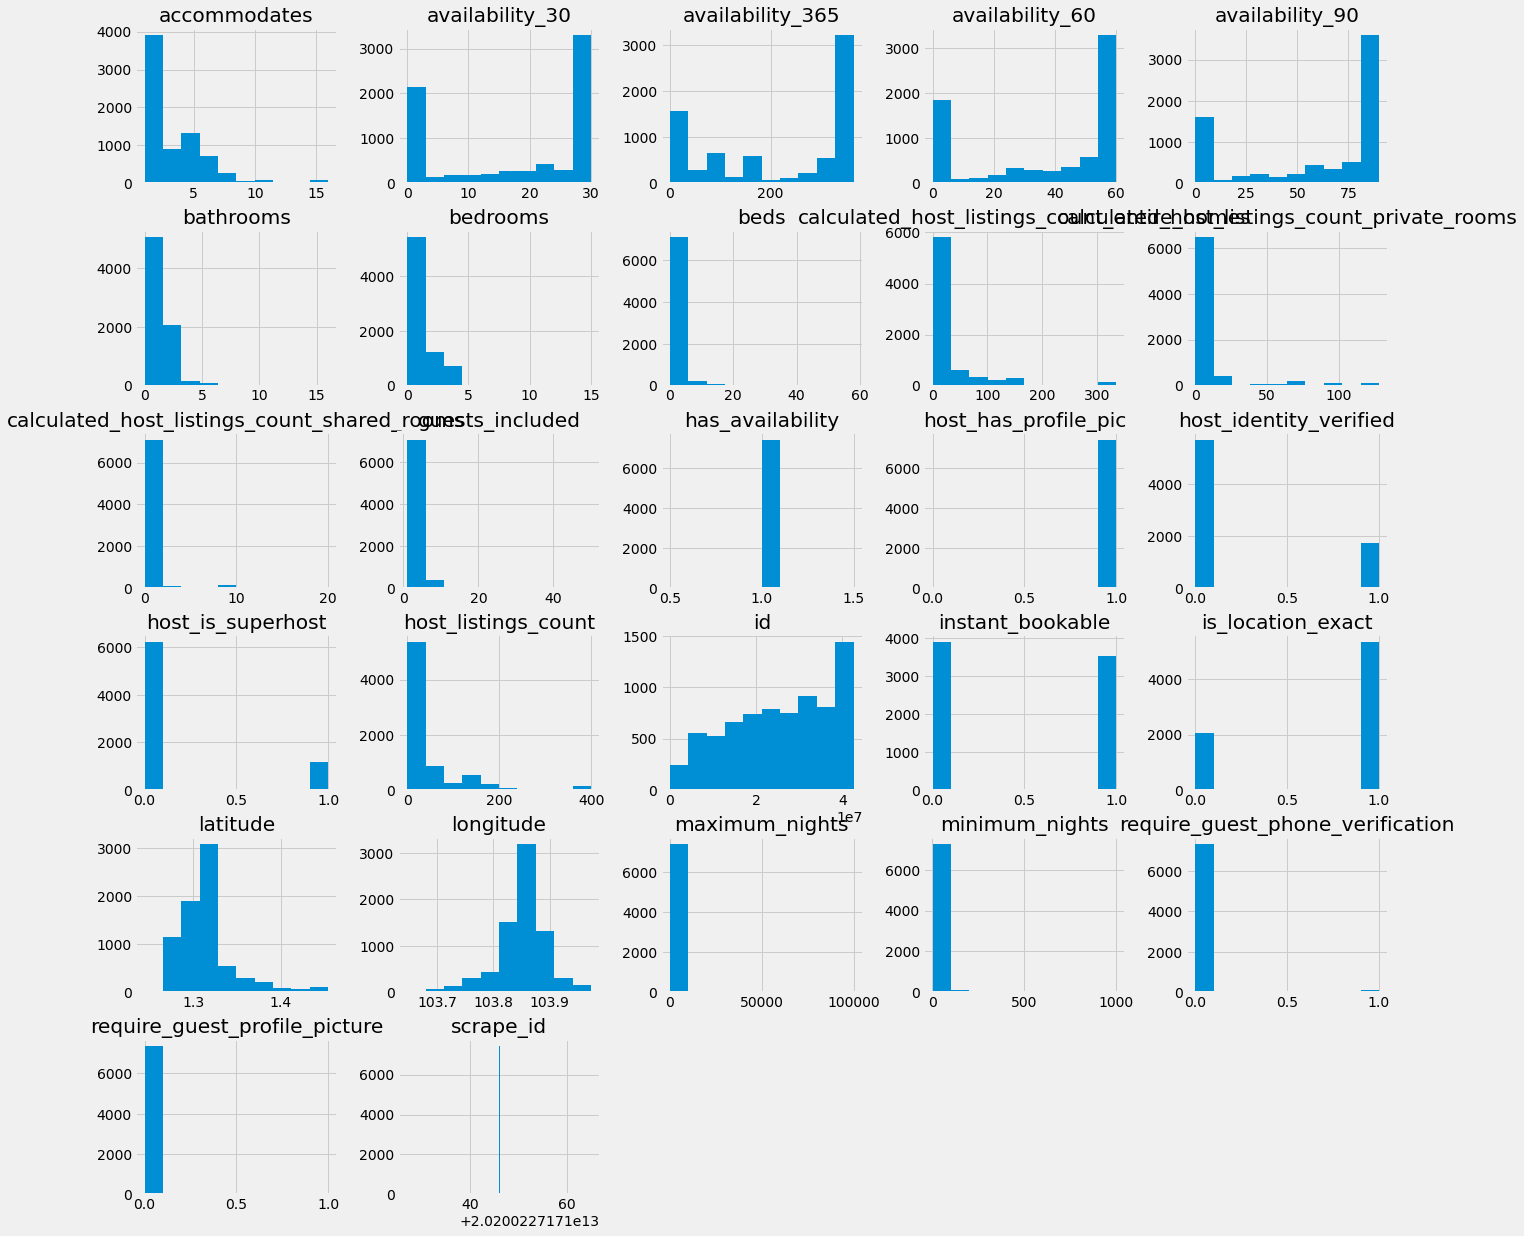

In [25]:
# Replacing columns with f/t with 0/1

airbnb_data.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories

airbnb_data.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [26]:
airbnb_data.drop(['has_availability',
                  'host_has_profile_pic', 
                  'maximum_nights', 
                  'require_guest_phone_verification', 
                  'require_guest_profile_picture',
                  'scrape_id'], axis=1, inplace=True)

In [27]:
airbnb_data.amenities

0       {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1       {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2       {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
3       {TV,Wifi,"Air conditioning",Kitchen,"Pets live...
4       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
                              ...                        
8042    {TV,"Cable TV",Wifi,"Air conditioning",Pool,Ki...
8043    {TV,"Cable TV",Wifi,"Air conditioning",Pool,Ki...
8044    {TV,"Cable TV",Wifi,"Air conditioning",Pool,Ki...
8045    {TV,Wifi,"Air conditioning",Pool,Kitchen,Gym,E...
8046    {TV,Wifi,"Air conditioning",Pool,Kitchen,Gym,E...
Name: amenities, Length: 7429, dtype: object

In [28]:
airbnb_data.amenities = airbnb_data.amenities.str.replace('{','')
airbnb_data.amenities = airbnb_data.amenities.str.replace('}', '')
airbnb_data.amenities = airbnb_data.amenities.str.replace('"', '')
airbnb_data.amenities = airbnb_data.amenities.str.split(',')

In [29]:
airbnb_data.amenities

0       [TV, Cable TV, Internet, Wifi, Air conditionin...
1       [TV, Cable TV, Internet, Wifi, Air conditionin...
2       [TV, Cable TV, Wifi, Air conditioning, Kitchen...
3       [TV, Wifi, Air conditioning, Kitchen, Pets liv...
4       [TV, Internet, Wifi, Air conditioning, Kitchen...
                              ...                        
8042    [TV, Cable TV, Wifi, Air conditioning, Pool, K...
8043    [TV, Cable TV, Wifi, Air conditioning, Pool, K...
8044    [TV, Cable TV, Wifi, Air conditioning, Pool, K...
8045    [TV, Wifi, Air conditioning, Pool, Kitchen, Gy...
8046    [TV, Wifi, Air conditioning, Pool, Kitchen, Gy...
Name: amenities, Length: 7429, dtype: object

In [30]:
airbnb_data.amenities = airbnb_data.amenities.str.join(',')

In [31]:
airbnb_data[['amenities']]

,amenities
0,"TV,Cable TV,Internet,Wifi,Air conditioning,Pet..."
1,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo..."
2,"TV,Cable TV,Wifi,Air conditioning,Kitchen,Pets..."
3,"TV,Wifi,Air conditioning,Kitchen,Pets live on ..."
4,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets..."
...,...
8042,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen..."
8043,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen..."
8044,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen..."
8045,"TV,Wifi,Air conditioning,Pool,Kitchen,Gym,Elev..."


In [32]:
airbnb_data.cancellation_policy.value_counts()

strict_14_with_grace_period    4786
flexible                       1469
moderate                       1165
super_strict_60                   7
super_strict_30                   2
Name: cancellation_policy, dtype: int64

In [33]:
airbnb_data.dtypes

id                                                int64
host_since                                       object
host_is_superhost                                 int64
host_listings_count                               int64
host_verifications                               object
host_identity_verified                            int64
street                                           object
neighbourhood_cleansed                           object
neighbourhood_group_cleansed                     object
smart_location                                   object
latitude                                        float64
longitude                                       float64
is_location_exact                                 int64
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms                                        

In [34]:
# convert price to integer, string because of currency
airbnb_data.price = airbnb_data.price.str[1:-3]
airbnb_data.price = airbnb_data.price.str.replace(",", "")
airbnb_data.price = airbnb_data.price.astype('int64')

In [35]:
# convert price to integer, string because of currency
airbnb_data.cleaning_fee = airbnb_data.cleaning_fee.str.replace("$", "")
airbnb_data.cleaning_fee = airbnb_data.cleaning_fee.fillna(0)
airbnb_data.cleaning_fee = airbnb_data.cleaning_fee.astype('float64')

In [36]:
# convert price to integer, string because of currency
airbnb_data.security_deposit = airbnb_data.security_deposit.str.replace("$", "")
airbnb_data.security_deposit = airbnb_data.security_deposit.str.replace(",", "")
airbnb_data.security_deposit = airbnb_data.security_deposit.fillna(0)
airbnb_data.security_deposit = airbnb_data.security_deposit.astype('float64')

In [37]:
# convert price to integer, string because of currency
airbnb_data.extra_people = airbnb_data.extra_people.str.replace("$", "")
airbnb_data.extra_people = airbnb_data.extra_people.fillna(0)
airbnb_data.extra_people = airbnb_data.extra_people.astype('float64')

## EDA
---
---
### Distribution of target value - Price

In [38]:
print(f"Nightly advertised prices range from ${min(airbnb_data.price)} to ${max(airbnb_data.price)}.")

Nightly advertised prices range from $0 to $10000.


In [39]:
# price should not be zero

airbnb_data.loc[airbnb_data['price']==0,:]

# drop the one that contains zero

,id,host_since,host_is_superhost,host_listings_count,host_verifications,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
2825,21408571,2017-02-03,0,5,"['email', 'phone', 'facebook', 'google', 'revi...",1,"Singapore, Singapore",Rochor,Central Region,Singapore,1.30954,103.85271,1,Condominium,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",0,0.0,15.0,1,10.0,1,2 weeks ago,20,39,69,340,1,moderate,2,2,0


In [40]:
airbnb_data = airbnb_data.loc[airbnb_data['price']>0,:]

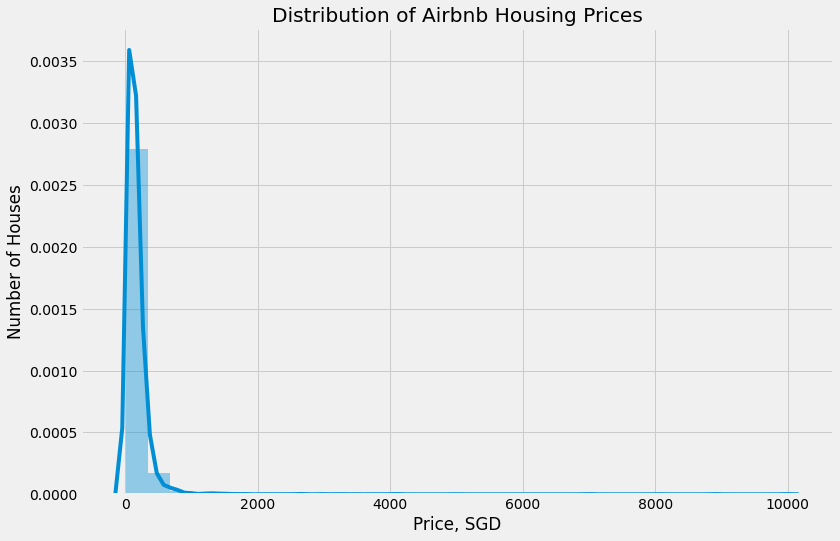

In [41]:
# View the distribution of the target-y, Price'

plt.figure(figsize = (12,8));
sns.distplot(airbnb_data.price, bins = 30, kde = True);
plt.xlabel('Price, SGD')
plt.ylabel('Number of Houses')
plt.title('Distribution of Airbnb Housing Prices');

In [42]:
# Distribution plot below shows that the price is skewed to the right 
# that is longer tail at right, where mean > mode

print(f"Skew is: {airbnb_data.price.skew()}")

#Try to convert to log scale and check the skewness

print(f"After convert to log scale, skew is: {np.log(airbnb_data.price).skew()}")

# The skewness is much closer to 0, which is closer to normal distribution

Skew is: 18.63032870062051
After convert to log scale, skew is: 0.35905855777584017


(6.0, 18.0)

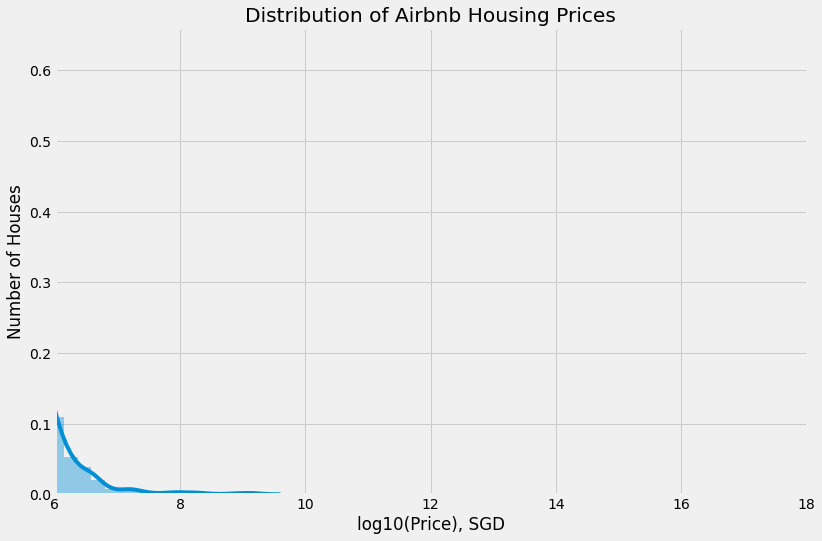

In [43]:
# View the distribution of the price after converting to log scale

plt.figure(figsize = (12,8));

sns.distplot(np.log(airbnb_data.price), bins = 30, kde = True);

plt.xlabel('log10(Price), SGD')
plt.ylabel('Number of Houses')
plt.title('Distribution of Airbnb Housing Prices');

plt.xlim(6,18)

### Numerical Features

In [44]:
# List out all the numerical features

num_features = airbnb_data.select_dtypes(include=[np.number])

# Return a subset of the DataFrame’s columns based on the column dtypes = numeric number

print(f' Total number of numeric features: {num_features.shape[1]}')
num_features.dtypes

 Total number of numeric features: 25


id                                                int64
host_is_superhost                                 int64
host_listings_count                               int64
host_identity_verified                            int64
latitude                                        float64
longitude                                       float64
is_location_exact                                 int64
accommodates                                      int64
bathrooms                                       float64
bedrooms                                        float64
beds                                            float64
price                                             int64
security_deposit                                float64
cleaning_fee                                    float64
guests_included                                   int64
extra_people                                    float64
minimum_nights                                    int64
availability_30                                 

#### Numerical features Vs Price
---
There is a total of 22 numerical features. Taking a quick view of how they correlate with price.

In [45]:
# Numeric features correlation 

num_features_corr = airbnb_data.corr()[['price']]

#List of correction of sale price versus the 22 numerical features

num_features_corr.sort_values(by = ['price'], ascending = False).T

,price,accommodates,bedrooms,extra_people,guests_included,cleaning_fee,beds,bathrooms,security_deposit,calculated_host_listings_count_entire_homes,host_listings_count,id,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_is_superhost,minimum_nights,longitude,instant_bookable,host_identity_verified,calculated_host_listings_count_shared_rooms,latitude,calculated_host_listings_count_private_rooms
price,1.0,0.231524,0.225072,0.159614,0.157283,0.125232,0.11469,0.101275,0.097103,0.053103,0.04869,0.041418,0.038494,0.032977,0.032653,0.029013,0.003139,0.000648,-0.00948,-0.038175,-0.042693,-0.044935,-0.051917,-0.090591,-0.091948


In [46]:
# To list out features with stong postive and strong negative correlation with price:
strong_pos = num_features_corr['price'] > 0.2   
strong_neg = num_features_corr['price'] < -0.1 

strong_nfeatures = num_features_corr[strong_pos | strong_neg].index   # list of features with strong correlation to price
print(f'Total of {num_features_corr[strong_pos | strong_neg].shape[0] -1} strong correlation features')

num_features_corr[strong_pos | strong_neg].sort_values(by = 'price', ascending = False).T

Total of 2 strong correlation features


,price,accommodates,bedrooms
price,1.0,0.231524,0.225072


In [47]:
# Unstack the correlation matrix (extract those with strong positive correlation among the numeric features)

x = airbnb_data.corr().unstack()
x[ ((x>0.6) & (x<1.0)) ]

host_listings_count                          calculated_host_listings_count_entire_homes    0.894452
accommodates                                 bedrooms                                       0.670952
                                             beds                                           0.641532
bedrooms                                     accommodates                                   0.670952
beds                                         accommodates                                   0.641532
availability_30                              availability_60                                0.955427
                                             availability_90                                0.910903
                                             availability_365                               0.634200
availability_60                              availability_30                                0.955427
                                             availability_90                               

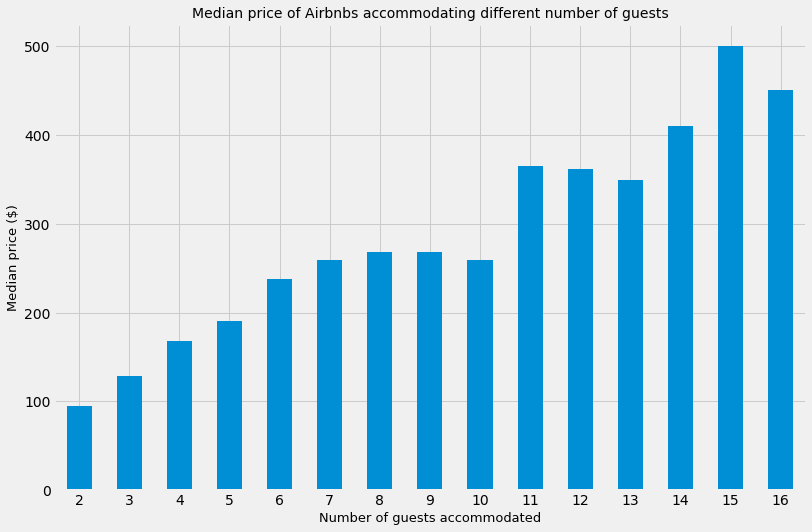

In [48]:
plt.figure(figsize=(12,8))
airbnb_data.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

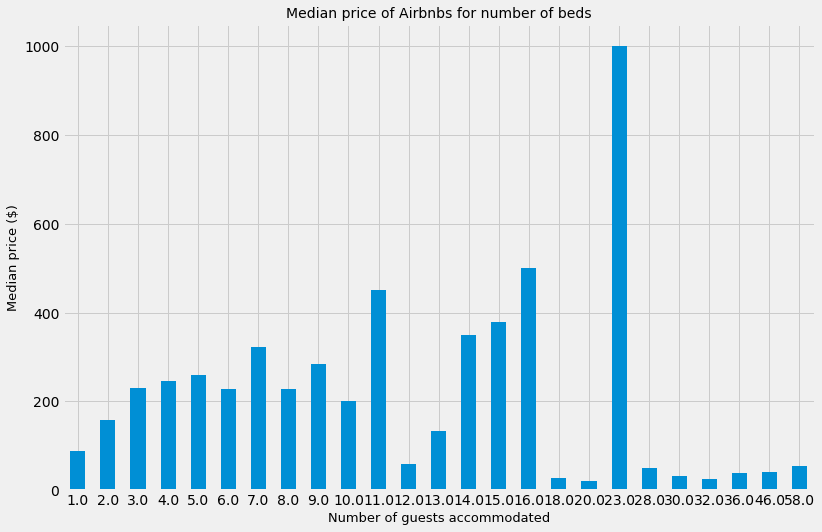

In [49]:
plt.figure(figsize=(12,8))
airbnb_data.groupby('beds').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs for number of beds', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

Seems like there isn't a very strong correlation between the numerical features and the price.

Bedrooms and accomodates have the greatest correlation to price but even so the value of correlation is low at 0.2.

From above we can also see that bedrooms and accomodates have a positive correlation of 0.67, and perhaps indication of multicollinearity.

#### Categorical Features

In [50]:
# List out all the categorical features

cat_features = airbnb_data.select_dtypes(include=[object])

# Return a subset of the DataFrame’s columns based on the column dtypes = object

print(f' Total number of categorical features: {cat_features.shape[1]}')
cat_features.dtypes

 Total number of categorical features: 12


host_since                      object
host_verifications              object
street                          object
neighbourhood_cleansed          object
neighbourhood_group_cleansed    object
smart_location                  object
property_type                   object
room_type                       object
bed_type                        object
amenities                       object
calendar_updated                object
cancellation_policy             object
dtype: object

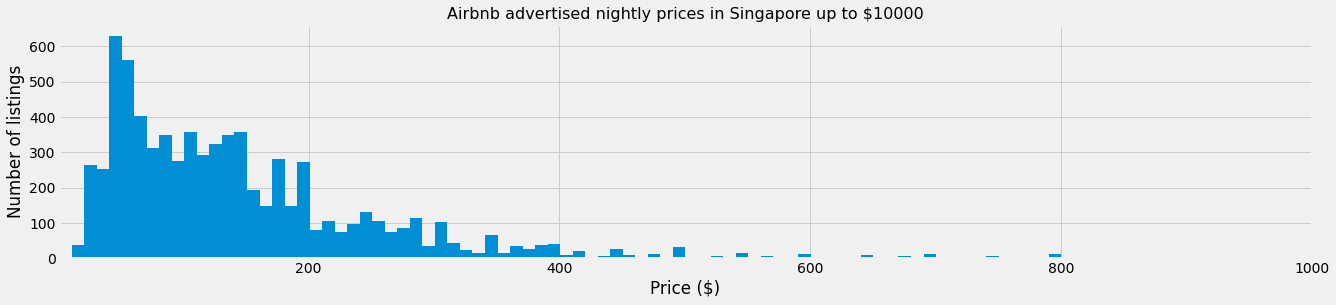

In [51]:
# Distribution of prices from $1 to $10000
plt.figure(figsize=(20,4))
airbnb_data.price.hist(bins=100, range=(1,1000))
plt.margins(x=0)
# plt.axvline(1, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Singapore up to $10000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [52]:
def category_count_plot(col, figsize=(20,8)):
 
    plt.figure(figsize=figsize)
    airbnb_data[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45, fontsize = 12)
    plt.show();

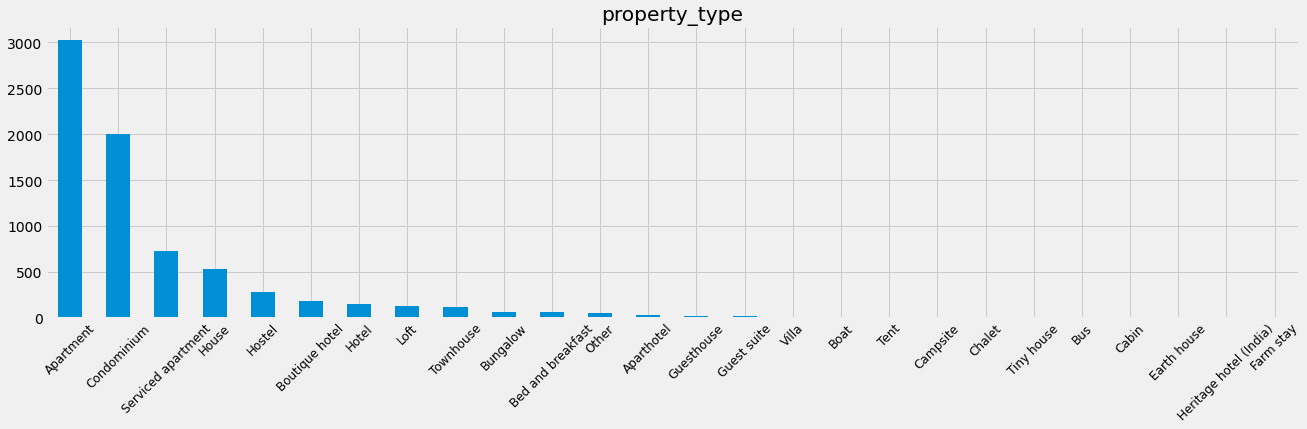

Apartment                 0.407108
Condominium               0.269790
Serviced apartment        0.098008
House                     0.070948
Hostel                    0.037830
Boutique hotel            0.024233
Hotel                     0.019655
Loft                      0.016828
Townhouse                 0.016290
Bungalow                  0.008481
Bed and breakfast         0.008347
Other                     0.006462
Aparthotel                0.004443
Guesthouse                0.003366
Guest suite               0.003231
Villa                     0.001616
Boat                      0.000808
Tent                      0.000808
Campsite                  0.000404
Chalet                    0.000404
Tiny house                0.000269
Bus                       0.000135
Cabin                     0.000135
Earth house               0.000135
Heritage hotel (India)    0.000135
Farm stay                 0.000135
Name: property_type, dtype: float64


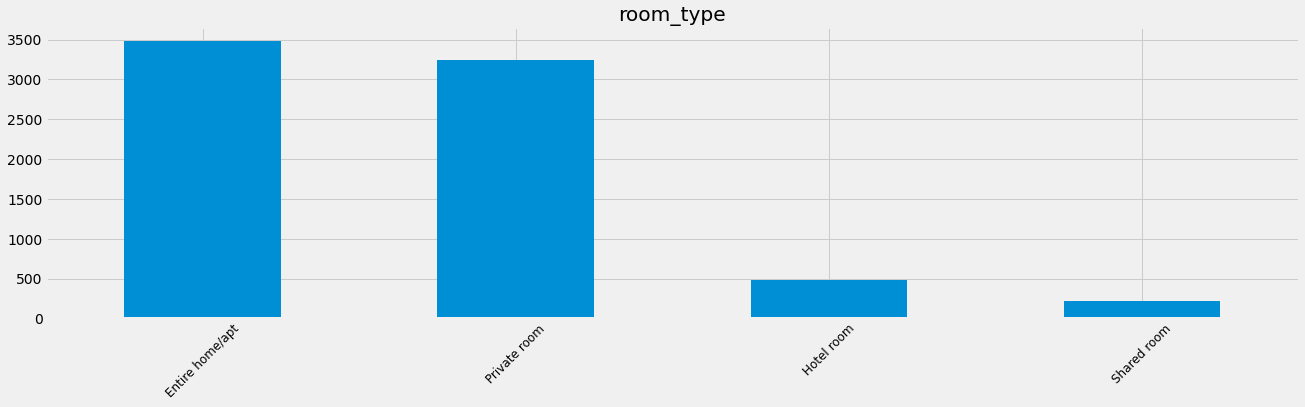

Entire home/apt    0.469171
Private room       0.435784
Hotel room         0.064890
Shared room        0.030156
Name: room_type, dtype: float64


In [53]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(20,5))
    print(airbnb_data[col].value_counts(normalize=True));

In [54]:
# looking at amenities

airbnb_data.amenities

0       TV,Cable TV,Internet,Wifi,Air conditioning,Pet...
1       TV,Cable TV,Internet,Wifi,Air conditioning,Poo...
2       TV,Cable TV,Wifi,Air conditioning,Kitchen,Pets...
3       TV,Wifi,Air conditioning,Kitchen,Pets live on ...
4       TV,Internet,Wifi,Air conditioning,Kitchen,Pets...
                              ...                        
8042    TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...
8043    TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...
8044    TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...
8045    TV,Wifi,Air conditioning,Pool,Kitchen,Gym,Elev...
8046    TV,Wifi,Air conditioning,Pool,Kitchen,Gym,Elev...
Name: amenities, Length: 7428, dtype: object

In [55]:
# getting a list of all amenities present

amenities_all = list(airbnb_data.amenities)
amenities_all = " ".join(amenities_all)
amenities_all = amenities_all.replace('{', '')
amenities_all = amenities_all.replace('}', ',')
amenities_all = amenities_all.replace('"', '')

In [56]:
# list comprehension to get amenities into one list

amenities_list = [x.strip() for x in amenities_all.split(',')]

In [57]:
# taking a look at the top 20 amenities

amenities_list = pd.Series(amenities_list)
amenities_count_top20 = amenities_list.value_counts().head(20)

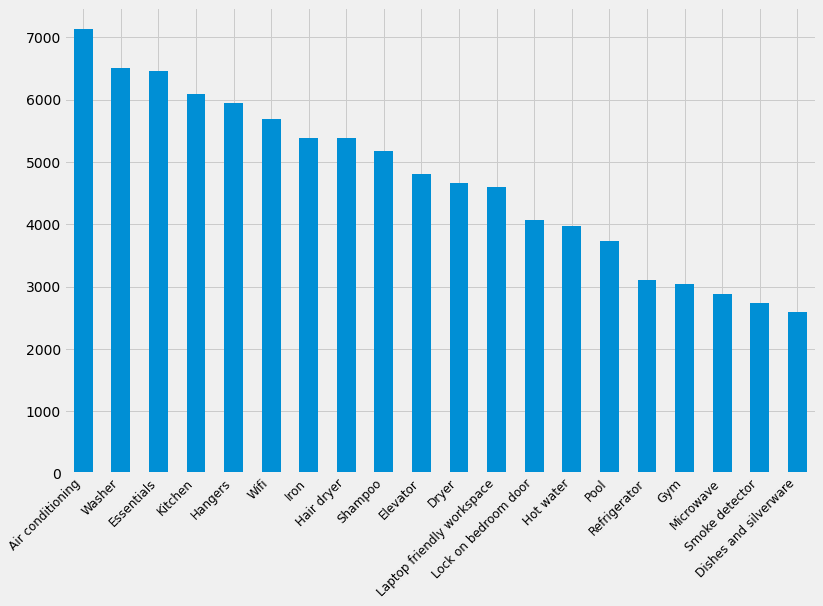

In [58]:
plt.figure(figsize=(12,8))
amenities_count_top20.plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

In [59]:
airbnb_data.to_csv('../data/listings_cleaned.csv', index = False)

## EDA & Modeling